In [2]:
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [3]:
from google.colab import files
files.upload()
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.53G/1.54G [00:15<00:00, 160MB/s]
100% 1.54G/1.54G [00:15<00:00, 107MB/s]


In [5]:
import zipfile
local_zip = '/content/100-bird-species.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [6]:
#Creating generator for Training DataSet
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('/content/train',target_size=(224, 224),batch_size=64,class_mode='categorical')

#Creating generator for Validation DataSet
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory('/content/valid',target_size=(224, 224),batch_size=32,class_mode='categorical')

#Creating generator for Test DataSet
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory('/content/test',target_size=(224, 224),batch_size=32,class_mode='categorical')

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [7]:
#instantiate a base model with pre-trained weigts.
base_model=keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


In [8]:
#freeze the base model
base_model.trainable = False

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(250,activation='softmax',kernel_initializer='glorot_normal'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               5

In [11]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history=model.fit(train_generator,epochs=40,validation_data=val_generator,workers=10)

Epoch 1/40
551/551 [==============================] - 379s 677ms/step - loss: 6.6077 - accuracy: 0.0680 - val_loss: 3.8726 - val_accuracy: 0.2576
Epoch 2/40
551/551 [==============================] - 369s 659ms/step - loss: 3.9439 - accuracy: 0.2673 - val_loss: 2.0177 - val_accuracy: 0.5912
Epoch 3/40
551/551 [==============================] - 355s 632ms/step - loss: 2.8495 - accuracy: 0.4469 - val_loss: 1.1658 - val_accuracy: 0.7320
Epoch 4/40
551/551 [==============================] - 353s 629ms/step - loss: 2.2249 - accuracy: 0.5596 - val_loss: 0.8455 - val_accuracy: 0.8000
Epoch 5/40
551/551 [==============================] - 351s 626ms/step - loss: 1.8785 - accuracy: 0.6214 - val_loss: 0.6638 - val_accuracy: 0.8392
Epoch 6/40
551/551 [==============================] - 355s 633ms/step - loss: 1.6419 - accuracy: 0.6701 - val_loss: 0.6108 - val_accuracy: 0.8592
Epoch 7/40
551/551 [==============================] - 348s 621ms/step - loss: 1.4675 - accuracy: 0.7074 - val_loss: 0.5298 -

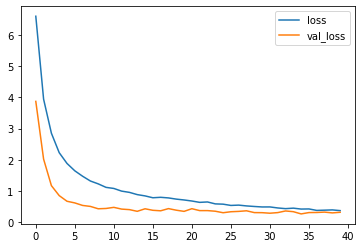

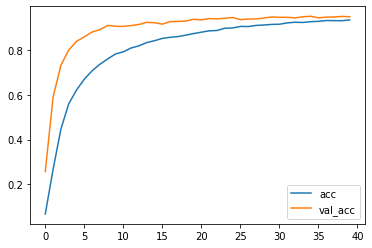

In [15]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [16]:
model.save("/content/birds.h5")

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!cp birds.h5 drive/MyDrive/

In [18]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

40/40 [==============================] - 7s 131ms/step - loss: 0.1709 - accuracy: 0.9632


[0.17085152864456177, 0.9631999731063843]